In [3]:
%pylab inline
import sys
sys.path.append('../')

import nltk
from nltk.corpus import stopwords

import re
import operator
import random as rnd

from time import time

s=stopwords.words('english') + ['']

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

engine = create_engine("sqlite:///../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

category_name = "cond-mat"

#ML

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.grid_search import GridSearchCV

vectorizer = CountVectorizer()


Populating the interactive namespace from numpy and matplotlib


/Users/michelle/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
#These are pretty popular:
journals = [["Phys Rev Lett", "Physical Review Letters","PRL", "Phys. Rev. Lett."], \
            ["Phys Rev B","Physical Review B", "PRB", "Phys. Rev. B"], \
            ["Nature","Nat", "Nat.","Science"]]
            
result_by_journal=[]
for idx,j_list in enumerate(journals):
    if type(j_list) == str:
        query = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref.like("%"+j_list+"%"))
        result_by_journal.insert(idx,query.all())
    elif j_list == None:
        query = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref==None)
        result_by_journal.insert(idx,query.all())
    else:
        for k in range(len(j_list)):
            query = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref.like("%"+j_list[k]+"%"))
            if k==0:
                result_by_journal.insert(idx,query.all())
            else:
                result_by_journal[idx]+=query.all()

In [17]:
#Make training set including **set_size** examples per journal.
def make_training_set(set_size, journal_name, result_by_journal):
    '''Takes the size of the training set desired, journal name for one vs all classifier, 
        and list of all returns from query.
        journal_name: 0 == PRL; 1==PRB; 2==Nature etc.'''

    PRL_len = len(result_by_journal[0])
    PRB_len = len(result_by_journal[1])
    Nat_len = len(result_by_journal[2])

    if set_size > min([PRL_len,PRB_len,Nat_len]):
        print("This is going to fail: set size must be less than "+str(min([PRL_len,PRB_len,Nat_len])))
    
    #Randomize articles selected to prevent order bias.
    random_prl = rnd.sample(xrange(0,PRL_len),set_size)
    random_prb = rnd.sample(xrange(0,PRB_len),set_size)
    random_nat = rnd.sample(xrange(0,Nat_len),set_size)

    abstracts = []
    #pulls abstracts (by journal) from all items returned by query.
    for idx in range(len(result_by_journal)):
        j_abs=[]
        for jidx, item in enumerate(result_by_journal[idx]):
            j_abs.insert(jidx,item.article.abstract)
        abstracts.insert(idx,j_abs)

    #picks out abstracts by random index from each journal.  Inserts into total train list in journal order.
    test_corpus = []
    for idx in random_prl:
        test_corpus.insert(len(test_corpus),abstracts[0][idx])
    for idx in random_prb:
        test_corpus.insert(len(test_corpus),abstracts[1][idx])
    for idx in random_nat:
        test_corpus.insert(len(test_corpus),abstracts[2][idx])
    
    y_vals = zeros(set_size*3)
    if journal_name is 0:
        y_vals[:set_size] = 1
    elif journal_name is 1:
        y_vals[set_size:2*set_size] = 1
    elif journal_name is 2:
        y_vals[2*set_size:] = 1
        
    return test_corpus, y_vals


In [8]:
pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression()),
    ])

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
   'clf__C': np.logspace(-4,4,7)
}



In [35]:
#How much does regularization change fit?  Sometimes, quite a lot.

j_val = 0 #PRL
set_size = 2000 #number of articles taken from each of three journals.

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
t_corp, y_vals = make_training_set(set_size, j_val, result_by_journal)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
t0 = time()
grid_search.fit(t_corp, y_vals)
print("done in %0.3fs" % (time() - t0))

all_params = grid_search.grid_scores_
for item in all_params:
    print("Value of clf_C: %f \tScore: %0.3f" % (item[0]['clf__C'],item[1]))

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


#Conclusions from these results: overfitting is a problem.

Performing grid search...
('pipeline:', ['vect', 'tfidf', 'clf'])
parameters:
{'clf__C': array([  1.00000000e-04,   2.15443469e-03,   4.64158883e-02,
         1.00000000e+00,   2.15443469e+01,   4.64158883e+02,
         1.00000000e+04])}
Fitting 3 folds for each of 7 candidates, totalling 21 fits
done in 6.921s
Value of clf_C: 0.000100 	Score: 0.667
Value of clf_C: 0.002154 	Score: 0.667
Value of clf_C: 0.046416 	Score: 0.667
Value of clf_C: 1.000000 	Score: 0.694
Value of clf_C: 21.544347 	Score: 0.675
Value of clf_C: 464.158883 	Score: 0.667
Value of clf_C: 10000.000000 	Score: 0.664
Best score: 0.694
Best parameters set:
	clf__C: 1.0


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.7s finished


Performing grid search...
('pipeline:', ['vect', 'tfidf', 'clf'])
parameters:
{'clf__C': array([  1.00000000e-04,   2.15443469e-03,   4.64158883e-02,
         1.00000000e+00,   2.15443469e+01,   4.64158883e+02,
         1.00000000e+04])}


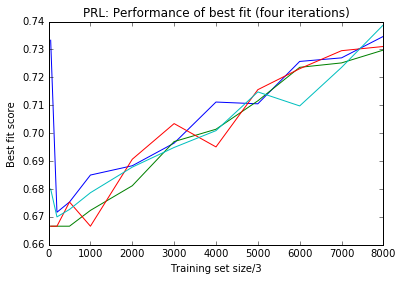

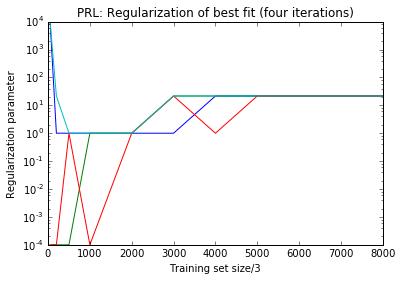

In [37]:
#PRL Test (cond-mat)
j_val = 0
n_trainsets = 4

#Turn verbosity off
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=0)

#Test the quality of the fit vs training set size.
set_sizes=[50, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

#Record as fcn of set_size
clfC = [[0 for i in range(len(set_sizes))] for j in range(n_trainsets)]
best_score = [[0 for i in range(len(set_sizes))] for j in range(n_trainsets)]

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)

for ss_idx, ss in enumerate(set_sizes):
    for k in range(n_trainsets):
        t_corp, y_vals = make_training_set(ss, j_val, result_by_journal)
        grid_search.fit(t_corp, y_vals)
        best_parameters = grid_search.best_estimator_.get_params()
        best_score[k][ss_idx] = grid_search.best_score_
        clfC[k][ss_idx] = best_parameters['clf__C']

        #print("Best score for size %g: %0.3f" % (ss, grid_search.best_score_)


#Plotting:        
for k in range(n_trainsets):
    plot(set_sizes, best_score[k])
xlabel('Training set size/3')
ylabel('Best fit score')
title('PRL: Performance of best fit (four iterations)')
show()
yscale('log')
for k in range(n_trainsets):
    plot(set_sizes, clfC[k])
xlabel('Training set size/3')
ylabel('Regularization parameter')
title('PRL: Regularization of best fit (four iterations)')
show()



Performing grid search...
('pipeline:', ['vect', 'tfidf', 'clf'])
parameters:
{'clf__C': array([  1.00000000e-04,   2.15443469e-03,   4.64158883e-02,
         1.00000000e+00,   2.15443469e+01,   4.64158883e+02,
         1.00000000e+04])}


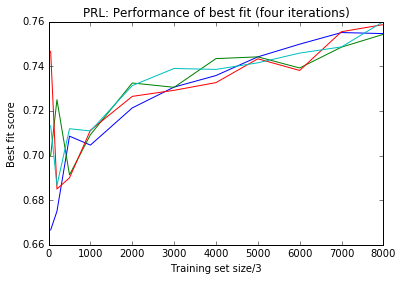

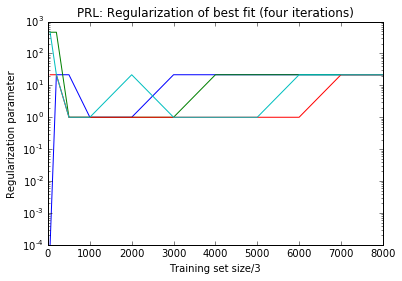

In [38]:
#PRB Test (cond-mat)
j_val = 1
n_trainsets = 4

#Turn verbosity off
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=0)
#Test the quality of the fit vs training set size.
set_sizes=[50, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

#Record as fcn of set_size
clfC = [[0 for i in range(len(set_sizes))] for j in range(n_trainsets)]
best_score = [[0 for i in range(len(set_sizes))] for j in range(n_trainsets)]

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)

for ss_idx, ss in enumerate(set_sizes):
    for k in range(n_trainsets):
        t_corp, y_vals = make_training_set(ss, j_val, result_by_journal)
        grid_search.fit(t_corp, y_vals)
        best_parameters = grid_search.best_estimator_.get_params()
        best_score[k][ss_idx] = grid_search.best_score_
        clfC[k][ss_idx] = best_parameters['clf__C']

        #print("Best score for size %g: %0.3f" % (ss, grid_search.best_score_)

#Plotting
for k in range(n_trainsets):
    plot(set_sizes, best_score[k])
xlabel('Training set size/3')
ylabel('Best fit score')
title('PRB: Performance of best fit (four iterations)')
show()
yscale('log')
for k in range(n_trainsets):
    plot(set_sizes, clfC[k])
xlabel('Training set size/3')
ylabel('Regularization parameter')
title('PRB: Regularization of best fit (four iterations)')
show()






Performing grid search...
('pipeline:', ['vect', 'tfidf', 'clf'])
parameters:
{'clf__C': array([  1.00000000e-04,   2.15443469e-03,   4.64158883e-02,
         1.00000000e+00,   2.15443469e+01,   4.64158883e+02,
         1.00000000e+04])}


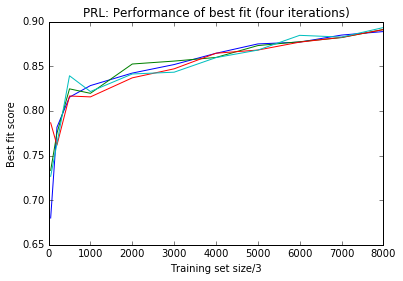

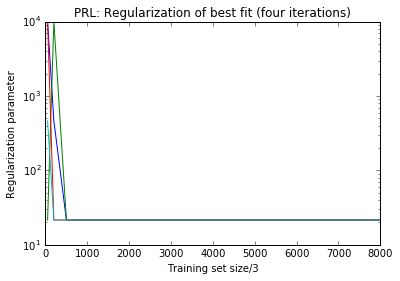

In [39]:
#Nat Test (cond-mat)
j_val = 2
n_trainsets = 4

#Turn verbosity off
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=0)

#Test the quality of the fit vs training set size.
set_sizes=[50, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

#Record as fcn of set_size
clfC = [[0 for i in range(len(set_sizes))] for j in range(n_trainsets)]
best_score = [[0 for i in range(len(set_sizes))] for j in range(n_trainsets)]

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)

for ss_idx, ss in enumerate(set_sizes):
    for k in range(n_trainsets):
        t_corp, y_vals = make_training_set(ss, j_val, result_by_journal)
        grid_search.fit(t_corp, y_vals)
        best_parameters = grid_search.best_estimator_.get_params()
        best_score[k][ss_idx] = grid_search.best_score_
        clfC[k][ss_idx] = best_parameters['clf__C']

        #print("Best score for size %g: %0.3f" % (ss, grid_search.best_score_)

#Plotting
for k in range(n_trainsets):
    plot(set_sizes, best_score[k])
xlabel('Training set size/3')
ylabel('Best fit score')
title('Nature: Performance of best fit (four iterations)')
show()
yscale('log')
for k in range(n_trainsets):
    plot(set_sizes, clfC[k])
xlabel('Training set size/3')
ylabel('Regularization parameter')
title('Nature: Regularization of best fit (four iterations)')
show()

